```{try_on_binder}
```

In [1]:

from IPython import get_ipython
ip = get_ipython()
if ip is not None:
    ip.run_line_magic('load_ext', 'pymor.discretizers.builtin.gui.jupyter')
    ip.run_line_magic('matplotlib', 'inline')

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
import pymor.tools.random
pymor.tools.random._default_random_state = None



The pymor.discretizers.builtin.gui.jupyter extension is already loaded. To reload it, use:
  %reload_ext pymor.discretizers.builtin.gui.jupyter


# Tutorial: Reducing an LTI system using balanced truncation


Here we briefly describe the balanced truncation method,
for asymptotically stable LTI systems with an invertible {math}`E` matrix,
and demonstrate it on the heat equation example from
{doc}`tutorial_lti_systems`.
First, we import necessary packages, including
{class}`~pymor.reductors.bt.BTReductor`.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sps
from pymor.models.iosys import LTIModel
from pymor.reductors.bt import BTReductor

plt.rcParams['axes.grid'] = True

Then we build the matrices

In [3]:

k = 50
n = 2 * k + 1

E = sps.eye(n, format='lil')
E[0, 0] = E[-1, -1] = 0.5
E = E.tocsc()

d0 = n * [-2 * (n - 1)**2]
d1 = (n - 1) * [(n - 1)**2]
A = sps.diags([d1, d0, d1], [-1, 0, 1], format='lil')
A[0, 0] = A[-1, -1] = -n * (n - 1)
A = A.tocsc()

B = np.zeros((n, 2))
B[:, 0] = 1
B[0, 0] = B[-1, 0] = 0.5
B[0, 1] = n - 1

C = np.zeros((3, n))
C[0, 0] = C[1, k] = C[2, -1] = 1


and form the full-order model.

In [4]:
fom = LTIModel.from_matrices(A, B, C, E=E)

## Balanced truncation

As the name suggests,
the balanced truncation method consists of
finding a *balanced* realization of the full-order LTI system and
*truncating* it to obtain a reduced-order model.

The balancing part is based on the fact that a single LTI system has many
realizations.
For example, starting from a realization

```{math}
\begin{align}
    E \dot{x}(t) & = A x(t) + B u(t), \\
    y(t) & = C x(t) + D u(t),
\end{align}
```

another realization can be obtained by replacing {math}`x(t)` with
{math}`T \tilde{x}(t)` or by pre-multiplying the differential equation with an
invertible matrix.
In particular, there exist invertible transformation matrices
{math}`T, S \in \mathbb{R}^{n \times n}` such that the realization with
{math}`\tilde{E} = S^{\operatorname{T}} E T = I`,
{math}`\tilde{A} = S^{\operatorname{T}} A T`,
{math}`\tilde{B} = S^{\operatorname{T}} B`,
{math}`\tilde{C} = C T`
has Gramians {math}`\tilde{P}` and {math}`\tilde{Q}` satisfying
{math}`\tilde{P} = \tilde{Q} = \Sigma = \operatorname{diag}(\sigma_i)`,
where {math}`\sigma_i` are the Hankel singular values
(see {doc}`tutorial_lti_systems` for more details).
Such a realization is called balanced.

The truncation part is based on the controllability and observability energies.
The controllability energy {math}`E_c(x_0)` is the minimum energy (squared
{math}`\mathcal{L}_2` norm of the input) necessary to steer the system from the
zero state to {math}`x_0`.
The observability energy {math}`E_o(x_0)` is the energy of the output (squared
{math}`\mathcal{L}_2` norm of the output) for a system starting at the state
{math}`x_0` and with zero input.
It can be shown for the balanced realization
(and same for any other realization)
that,
if {math}`\tilde{P}` is invertible,
then

```{math}
E_c(x_0) = x_0 \tilde{P}^{-1} x_0, \quad
E_o(x_0) = x_0 \tilde{Q} x_0.
```

Therefore, states corresponding to small Hankel singular values are more
difficult to reach (they have a large controllability energy) and are difficult
to observe (they produce a small observability energy).
In this sense, it is then reasonable to truncate these states.
This can be achieved by taking as basis matrices
{math}`V, W \in \mathbb{R}^{n \times r}` the first {math}`r` columns of
{math}`T` and {math}`S`,
possibly after orthonormalization,
giving a reduced-order model

```{math}
\begin{align}
    \hat{E} \dot{\hat{x}}(t)
    & = \hat{A} \hat{x}(t) + \hat{B} u(t), \\
    \hat{y}(t)
    & = \hat{C} \hat{x}(t) + D u(t),
\end{align}
```

with
{math}`\hat{E} = W^{\operatorname{T}} E V`,
{math}`\hat{A} = W^{\operatorname{T}} A V`,
{math}`\hat{B} = W^{\operatorname{T}} B`,
{math}`\hat{C} = C V`.

It is known that the reduced-order model is asymptotically stable if
{math}`\sigma_r > \sigma_{r + 1}`.
Furthermore, it satisfies the {math}`\mathcal{H}_\infty` error bound

```{math}
\lVert H - \hat{H} \rVert_{\mathcal{H}_\infty}
\leqslant 2 \sum_{i = r + 1}^n \sigma_i.
```

Note that any reduced-order model (not only from balanced truncation) satisfies
the lower bound

```{math}
\lVert H - \hat{H} \rVert_{\mathcal{H}_\infty}
\geqslant \sigma_{r + 1}.
```

## Balanced truncation in pyMOR

To run balanced truncation in pyMOR, we first need the reductor object

In [5]:
bt = BTReductor(fom)

Calling its {meth}`~pymor.reductors.bt.GenericBTReductor.reduce` method runs the
balanced truncation algorithm. This reductor additionally has an `error_bounds`
method which can compute the a priori {math}`\mathcal{H}_\infty` error bounds
based on the Hankel singular values:

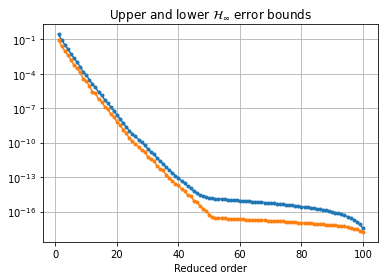

In [6]:
error_bounds = bt.error_bounds()
hsv = fom.hsv()
fig, ax = plt.subplots()
ax.semilogy(range(1, len(error_bounds) + 1), error_bounds, '.-')
ax.semilogy(range(1, len(hsv)), hsv[1:], '.-')
ax.set_xlabel('Reduced order')
_ = ax.set_title(r'Upper and lower $\mathcal{H}_\infty$ error bounds')

To get a reduced-order model of order 10, we call the `reduce` method with the
appropriate argument:

In [7]:
rom = bt.reduce(10)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Instead, or in addition, a tolerance for the {math}`\mathcal{H}_\infty` error
can be specified, as well as the projection algorithm (by default, the
balancing-free square root method is used).
The used Petrov-Galerkin bases are stored in `bt.V` and `bt.W`.

We can compare the magnitude plots between the full-order and reduced-order
models

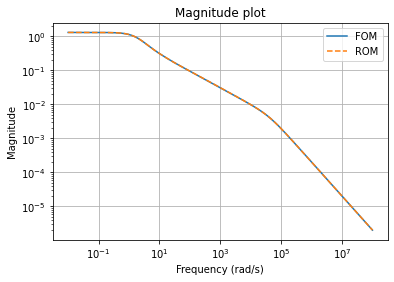

In [8]:
w = np.logspace(-2, 8, 300)
fig, ax = plt.subplots()
fom.mag_plot(w, ax=ax, label='FOM')
rom.mag_plot(w, ax=ax, linestyle='--', label='ROM')
_ = ax.legend()

as well as Bode plots

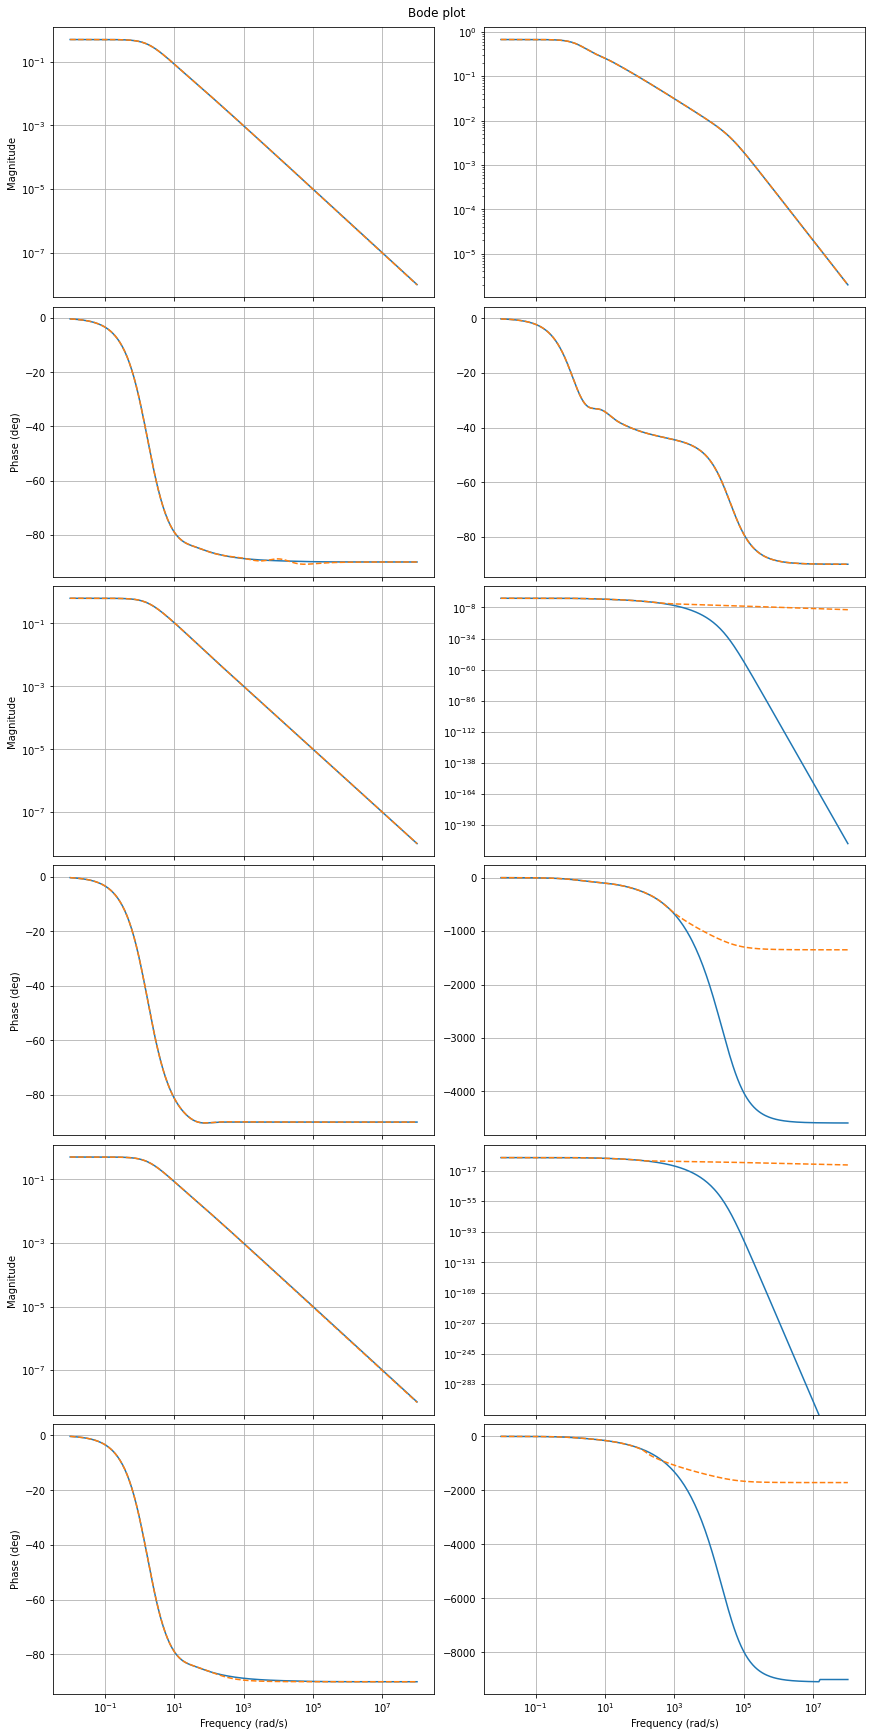

In [9]:
fig, axs = plt.subplots(6, 2, figsize=(12, 24), sharex=True, constrained_layout=True)
fom.bode_plot(w, ax=axs)
_ = rom.bode_plot(w, ax=axs, linestyle='--')

Also, we can plot the magnitude plot of the error system,
which is again an LTI system.

```{math}
\begin{align}
    \begin{bmatrix}
        E & 0 \\
        0 & \hat{E}
    \end{bmatrix}
    \begin{bmatrix}
        \dot{x}(t) \\
        \dot{\hat{x}}(t)
    \end{bmatrix}
    & =
    \begin{bmatrix}
        A & 0 \\
        0 & \hat{A}
    \end{bmatrix}
    \begin{bmatrix}
        x(t) \\
        \hat{x}(t)
    \end{bmatrix}
    +
    \begin{bmatrix}
        B \\
        \hat{B}
    \end{bmatrix}
    u(t), \\
    y(t) - \hat{y}(t)
    & =
    \begin{bmatrix}
        C & -\hat{C}
    \end{bmatrix}
    \begin{bmatrix}
        x(t) \\
        \hat{x}(t)
    \end{bmatrix}.
\end{align}
```

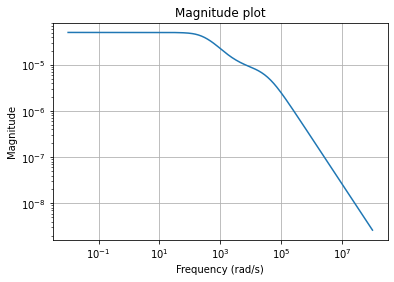

In [10]:
err = fom - rom
_ = err.mag_plot(w)

and its Bode plot

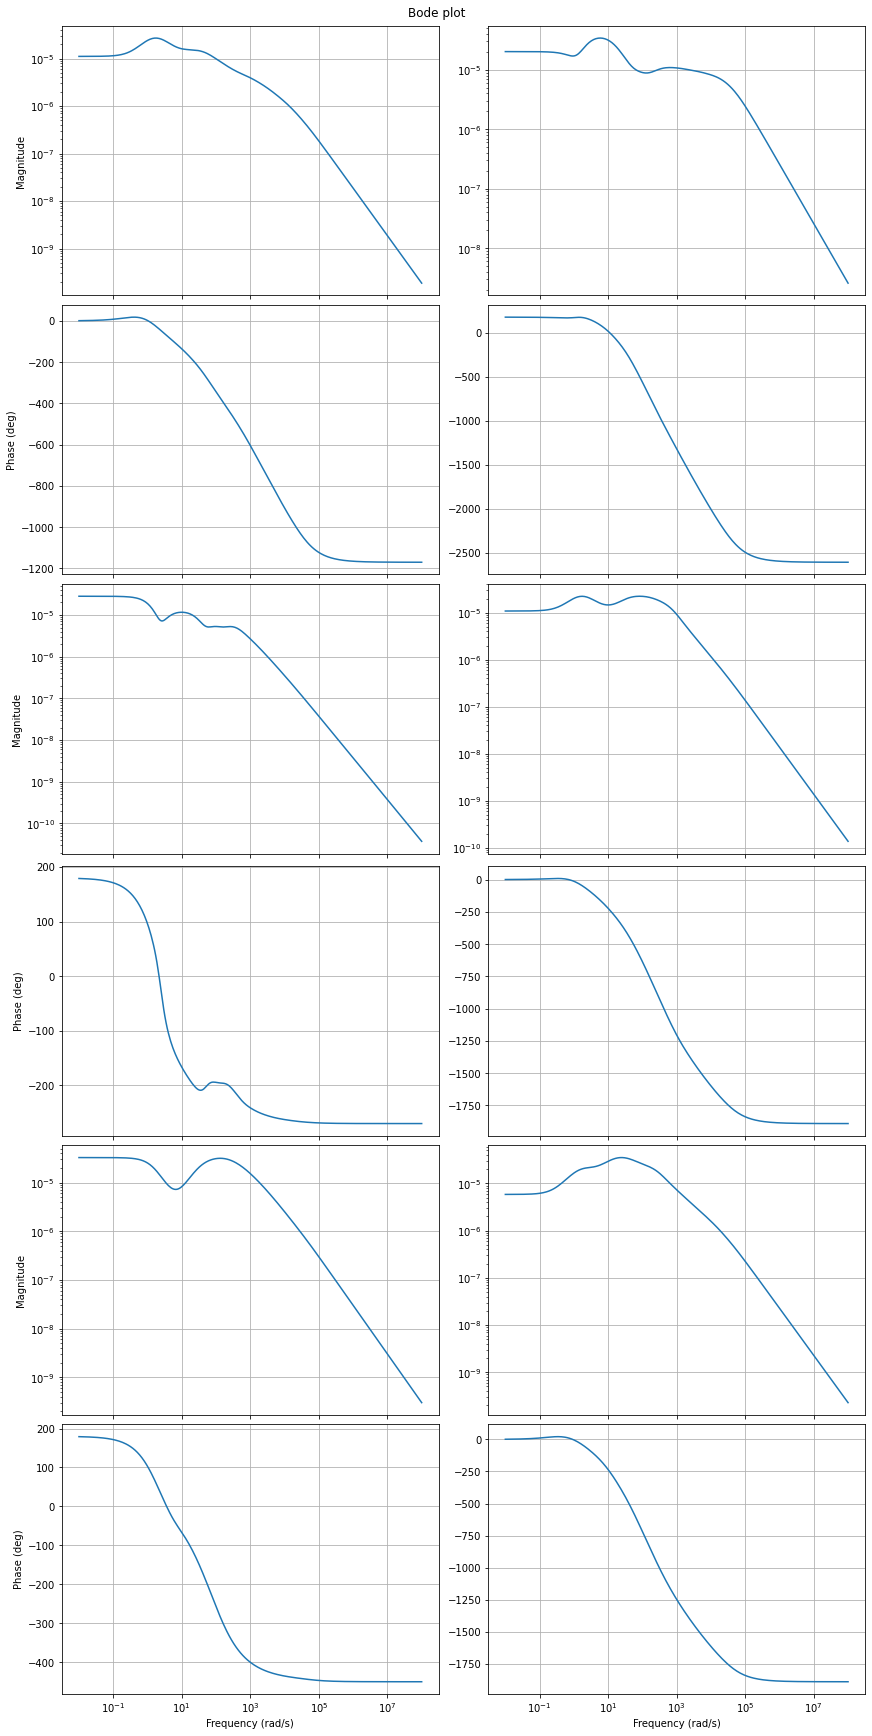

In [11]:
_ = err.bode_plot(w)

Finally, we can compute the relative errors in different system norms.

In [12]:
print(f'Relative Hinf error:   {err.hinf_norm() / fom.hinf_norm():.3e}')
print(f'Relative H2 error:     {err.h2_norm() / fom.h2_norm():.3e}')
print(f'Relative Hankel error: {err.hankel_norm() / fom.hankel_norm():.3e}')

Relative Hinf error:   3.702e-05
Relative H2 error:     6.399e-04
Relative Hankel error: 7.629e-05


Download the code:
{download}`tutorial_bt.md`,
{nb-download}`tutorial_bt.ipynb`.